# Monet CycleGAN

## 1. Introduction

This mini-project was made for the Kaggle challenge [“I’m Something of a Painter Myself”](https://www.kaggle.com/competitions/gan-getting-started/overview). The goal was to build a Generative Adversarial Network (GAN) model that can transform real photos into Monet-style paintings. The model uses two generators and two discriminators to learn the bidirectional mapping between photos and paintings. It was trained with a public dataset containing 300 Monet paintings and 7,028 photos, all sized 256×256 pixels and stored in TFRecord format.

The project mainly consists of the following steps:
1. **EDA (Image Inspection and Preprocessing)**: The images were loaded, inspected, normalized and batched for training.
2. **Model Architecture**: A CycleGAN model was built, consisting of two generators and two discriminators, designed to learn the transformation between Monet paintings and real photos.
3. **Image Generation and Results**: The trained and fine-tuned model was used to generate Monet-style images from real photos, which were submitted for evaluation on Kaggle.

## 2. EDA (Image Inspection and Preprocessing)

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

First of all, I ensured GPU was enabled to speed up model training and image generation.

In [4]:
print("# of GPUs Active:", len(tf.config.list_physical_devices('GPU')))

# of GPUs Active: 1


After normalization and batching, I verified the batch size and shape, then visualized several sample images from both the Monet and photo datasets to confirm correct preprocessing. In addition, I analyzed the pixel intensity, brightness, and saturation distributions of both datasets using 50 sample images. The visualizations helped to illustrate the differences in color, tone, and contrast between Monet paintings and real photos.

In [6]:
import os

monet_tfrec = '/kaggle/input/gan-getting-started/monet_tfrec'
photo_tfrec = '/kaggle/input/gan-getting-started/photo_tfrec'

IMAGE_SIZE = (256, 256)
IMAGE_SHAPE = (256, 256, 3)

monet_files = tf.io.gfile.glob(os.path.join(monet_tfrec, "*.tfrec"))
photo_files = tf.io.gfile.glob(os.path.join(photo_tfrec, "*.tfrec"))

AUTOTUNE = tf.data.AUTOTUNE

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0 # normalize to [-1, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def read_tfrecord(example):
    feature_description = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = decode_image(example["image"])
    return image


def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset


def get_dataset(filenames, batch_size=1):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset


monet_ds = get_dataset(monet_files)
for batch in monet_ds.take(1):
    print(batch.shape)
print(f"# of monet batches: {sum(1 for _ in monet_ds)}")

photo_ds = get_dataset(photo_files)
for batch in photo_ds.take(1):
    print(batch.shape)
print(f"# of photo batches: {sum(1 for _ in photo_ds)}")

(1, 256, 256, 3)
# of monet batches: 300
(1, 256, 256, 3)
# of photo batches: 7038


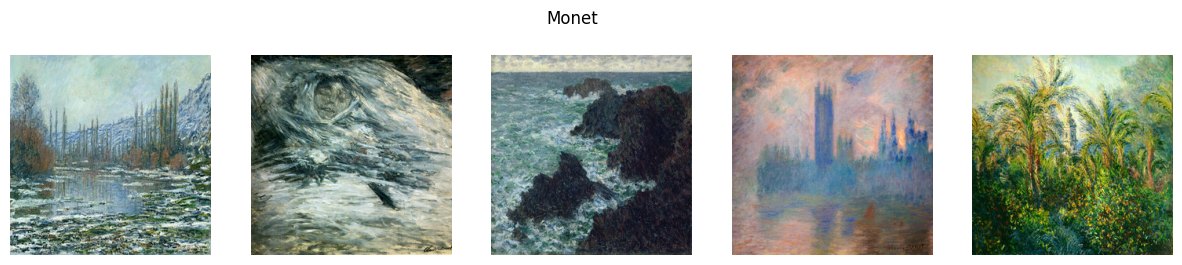

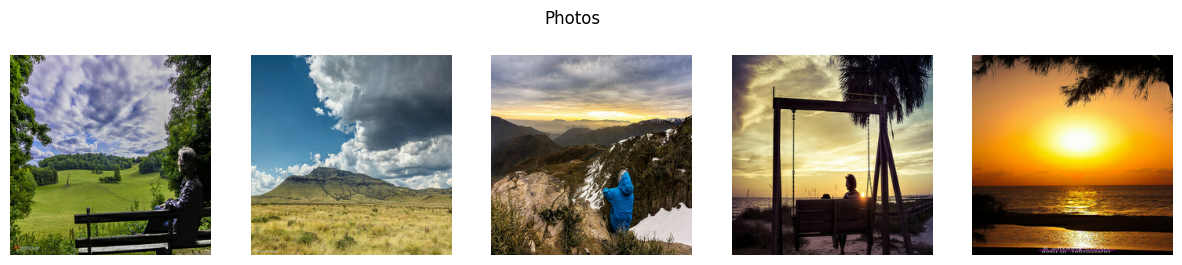

In [7]:
def show_sample_images(dataset, title, n=5):
    plt.figure(figsize=(15, 3))
    for i, batch in enumerate(dataset.take(n)):
        image = batch[0]
        plt.subplot(1, n, i + 1)
        plt.imshow((image * 0.5 + 0.5))  # rescale [-1,1] -> [0,1]
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_sample_images(monet_ds, "Monet")
show_sample_images(photo_ds, "Photos")

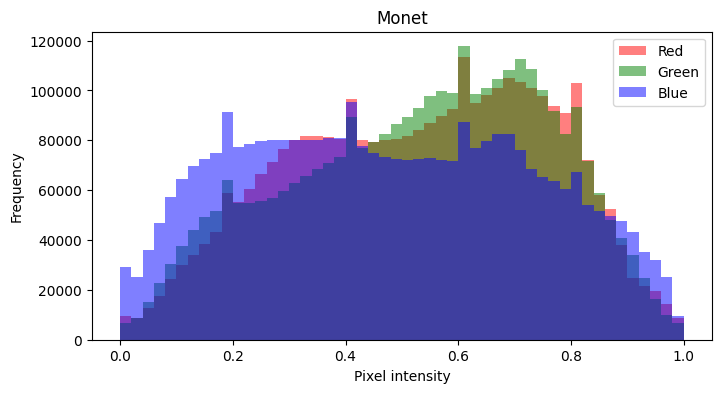

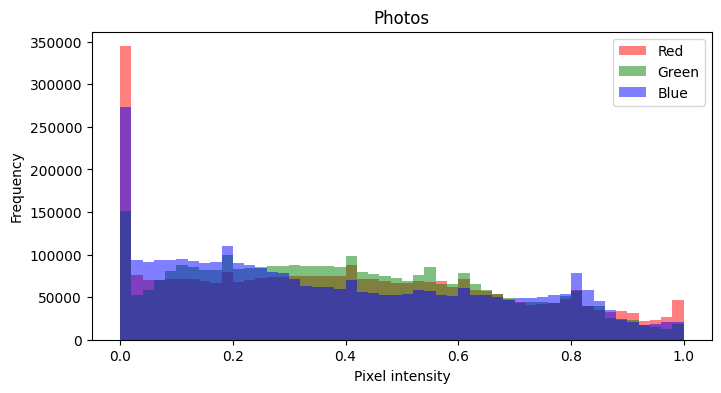

In [8]:
def plot_pixel_intensity(dataset, title, n=50):
    pixels = []
    for i, img in enumerate(dataset.take(n)):
        if isinstance(img, tuple) or len(img) == 2:
            img = img[0]
        img = (img + 1) / 2.0
        pixels.append(tf.reshape(img, [-1, 3]))
    pixels = tf.concat(pixels, axis=0).numpy()

    plt.figure(figsize=(8,4))
    plt.hist(pixels[:,0], bins=50, color='r', alpha=0.5, label='Red')
    plt.hist(pixels[:,1], bins=50, color='g', alpha=0.5, label='Green')
    plt.hist(pixels[:,2], bins=50, color='b', alpha=0.5, label='Blue')
    plt.title(title)
    plt.xlabel("Pixel intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_pixel_intensity(monet_ds, "Monet")
plot_pixel_intensity(photo_ds, "Photos")

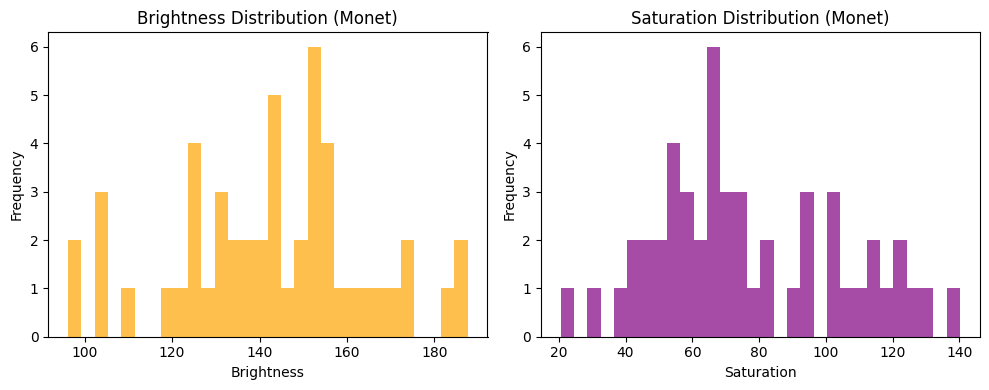

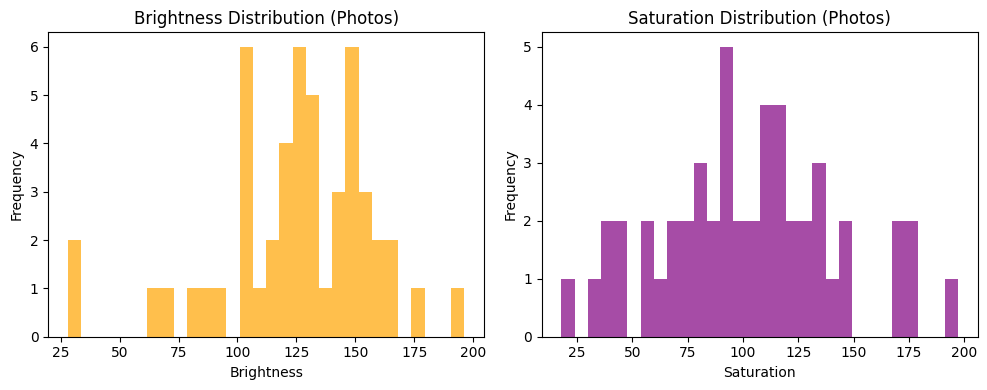

In [9]:
import cv2

def plot_brightness_saturation(dataset, title, n=50):
    brightness = []
    saturation = []
    count = 0
    for batch in dataset:
        if isinstance(batch, tuple):
            batch = batch[0]

        for img in batch:
            img_np = ((img + 1) * 127.5).numpy().astype(np.uint8)
            
            hsv = cv2.cvtColor(img_np, cv2.COLOR_RGB2HSV)

            brightness.append(hsv[:,:,2].mean())
            saturation.append(hsv[:,:,1].mean())
            
            count += 1
            if count >= n:
                break
        if count >= n:
            break

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.hist(brightness, bins=30, color='orange', alpha=0.7)
    plt.xlabel("Brightness")
    plt.ylabel("Frequency")
    plt.title(f"Brightness Distribution ({title})")

    plt.subplot(1,2,2)
    plt.hist(saturation, bins=30, color='purple', alpha=0.7)
    plt.xlabel("Saturation")
    plt.ylabel("Frequency")
    plt.title(f"Saturation Distribution ({title})")

    plt.tight_layout()
    plt.show()

plot_brightness_saturation(monet_ds, "Monet")
plot_brightness_saturation(photo_ds, "Photos")

## 3. Model Architecture

At first, I tried a classic GAN with one generator and one discriminator, where the generator took a random noise vector as input. However, even though the generator loss was low (around 0.4–0.5), the generated images were of low quality, and the model needed more training time to converge.

Then, I chose to use an image-to-image GAN (CycleGAN) with a U-Net generator because:
1. The images are unpaired (no one-to-one match between Monet painting and photo), and the CycleGAM architecture with two generators and two discriminators can learn transformations in both directions between the two image domains efficiently.
2. The U-Net's encoder (downsampling) and decoder (upsampling) structure with skip connections can capture both global and local features of the images, as well as preserve important details during translation.

The loss functions used for evaluation include the generator loss, discriminator loss, cycle-consistency loss, and identity loss. However, in a CycleGAN, these losses are more complex and harder to interpret compared to a traditional GAN with a single generator and discriminator.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5, gamma_initializer="ones", beta_initializer="zeros"):
        super().__init__()
        self.epsilon = epsilon
        self.gamma_initializer = gamma_initializer
        self.beta_initializer = beta_initializer

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.gamma_initializer,
                                     trainable=True)
        self.beta = self.add_weight(shape=(input_shape[-1],),
                                    initializer=self.beta_initializer,
                                    trainable=True)

    def call(self, x):
        mean, var = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        return self.gamma * (x - mean) / tf.sqrt(var + self.epsilon) + self.beta

In [11]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

### 3.1 Generator

In [12]:
def build_generator():
    inputs = layers.Input(shape=[256, 256, 3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh')

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x, name="Generator")

monet_g = build_generator()
photo_g = build_generator()
monet_g.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      3,072 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,195,328 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,389,632 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,389,632 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,414,979 (207.58 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Discriminator

In [13]:
def build_discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = layers.ZeroPadding2D()(down3)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1)

    norm1 = InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2)

    return tf.keras.Model(inputs=inp, outputs=last, name="Discriminator")

monet_d = build_discriminator()
photo_d = build_discriminator()
monet_d.summary()

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 128, 128, 64)   │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 64, 64, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 32, 32, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 34, 34, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 31, 31, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_30       │ (None, 31, 31, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 31, 31, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 33, 33, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 30, 30, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,569 (10.55 MB)

 Trainable params: 2,765,569 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

### 3.3 CycleGAN

In [14]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_g_optimizer,
        p_g_optimizer,
        m_d_optimizer,
        p_d_optimizer,
        g_loss_fn,
        d_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_g_optimizer = m_g_optimizer
        self.p_g_optimizer = p_g_optimizer
        self.m_d_optimizer = m_d_optimizer
        self.p_d_optimizer = p_d_optimizer
        self.g_loss_fn = g_loss_fn
        self.d_loss_fn = d_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            monet_g_loss = self.g_loss_fn(disc_fake_monet)
            photo_g_loss = self.g_loss_fn(disc_fake_photo)

            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            total_monet_g_loss = monet_g_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_g_loss = photo_g_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_d_loss = self.d_loss_fn(disc_real_monet, disc_fake_monet)
            photo_d_loss = self.d_loss_fn(disc_real_photo, disc_fake_photo)

        monet_generator_gradients = tape.gradient(total_monet_g_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_g_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_d_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_d_loss, self.p_disc.trainable_variables)

        self.m_g_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_g_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_d_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_d_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))
        
        return {
            "monet_g_loss": total_monet_g_loss,
            "photo_g_loss": total_photo_g_loss,
            "monet_d_loss": monet_d_loss,
            "photo_d_loss": photo_d_loss
        }

In [15]:
def d_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def g_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

### 3.4 Model Training

In [16]:
monet_g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

monet_d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
photo_d_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

cycle_gan = CycleGan(monet_g, photo_g, monet_d, photo_d)

cycle_gan.compile(
    m_g_optimizer = monet_g_optimizer,
    p_g_optimizer = photo_g_optimizer,
    m_d_optimizer = monet_d_optimizer,
    p_d_optimizer = photo_d_optimizer,
    g_loss_fn = g_loss,
    d_loss_fn = d_loss,
    cycle_loss_fn = cycle_loss,
    identity_loss_fn = identity_loss
)

In [17]:
cycle_gan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=10)

Epoch 1/10


I0000 00:00:1759912647.583525     105 service.cc:148] XLA service 0x7a301c019330 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759912647.584597     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1759912654.852197     105 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1759912685.328623     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 140s 150ms/step - monet_d_loss: 0.5832 - monet_g_loss: 6.1986 - photo_d_loss: 0.6103 - photo_g_loss: 6.3276
Epoch 2/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.5032 - monet_g_loss: 4.4430 - photo_d_loss: 0.5636 - photo_g_loss: 4.2914
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.5733 - monet_g_loss: 3.9869 - photo_d_loss: 0.5781 - photo_g_loss: 3.9238
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6147 - monet_g_loss: 3.8123 - photo_d_loss: 0.6159 - photo_g_loss: 3.7860
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6263 - monet_g_loss: 3.7035 - photo_d_loss: 0.6313 - photo_g_loss: 3.7022
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6192 - monet_g_loss: 3.5340 - photo_d_loss: 0.6194 - photo_g_loss: 3.5304
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6102 - monet_g_loss: 3.4908 - photo_d_loss: 0.6159 - photo_g_loss: 3.4706
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6292 - monet_g_loss: 3.3359 - photo_d_loss: 0.6289 - pho

### 3.5 Hyperparameter Tuning

During training, I noticed that the generator losses decreased over the training epochs, but they remained higher than the discriminators, indicating that the discriminators could easily distinguish between real and generated images. To improve the balance, I increased the learning rate for the generators from 1e-4 to 2e-4 to help them learn faster and produce more realistic outputs, and added 5 more training epochs.

In [19]:
monet_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

cycle_gan = CycleGan(monet_g, photo_g, monet_d, photo_d)

cycle_gan.compile(
    m_g_optimizer = monet_g_optimizer,
    p_g_optimizer = photo_g_optimizer,
    m_d_optimizer = monet_d_optimizer,
    p_d_optimizer = photo_d_optimizer,
    g_loss_fn = g_loss,
    d_loss_fn = d_loss,
    cycle_loss_fn = cycle_loss,
    identity_loss_fn = identity_loss
)

cycle_gan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs=15)

Epoch 1/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 137s 150ms/step - monet_d_loss: 0.6260 - monet_g_loss: 2.8453 - photo_d_loss: 0.5940 - photo_g_loss: 2.9774
Epoch 2/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6302 - monet_g_loss: 2.7809 - photo_d_loss: 0.6006 - photo_g_loss: 2.9076
Epoch 3/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6378 - monet_g_loss: 2.7760 - photo_d_loss: 0.5916 - photo_g_loss: 2.9193
Epoch 4/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6346 - monet_g_loss: 2.7491 - photo_d_loss: 0.6107 - photo_g_loss: 2.8745
Epoch 5/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6226 - monet_g_loss: 2.7137 - photo_d_loss: 0.5855 - photo_g_loss: 2.8702
Epoch 6/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6348 - monet_g_loss: 2.7272 - photo_d_loss: 0.5993 - photo_g_loss: 2.8807
Epoch 7/15
300/300 ━━━━━━━━━━━━━━━━━━━━ 46s 150ms/step - monet_d_loss: 0.6372 - monet_g_loss: 2.6950 - photo_d_loss: 

From the results, the increased learning rate reduced the losses of the generators to under 3. The discriminator losses were around 0.5-0.6, which is already an acceptable level. Further improvements might be achieved by using an even higher learning rate for generators and training for more epochs.

## 4. Image Generation and Results

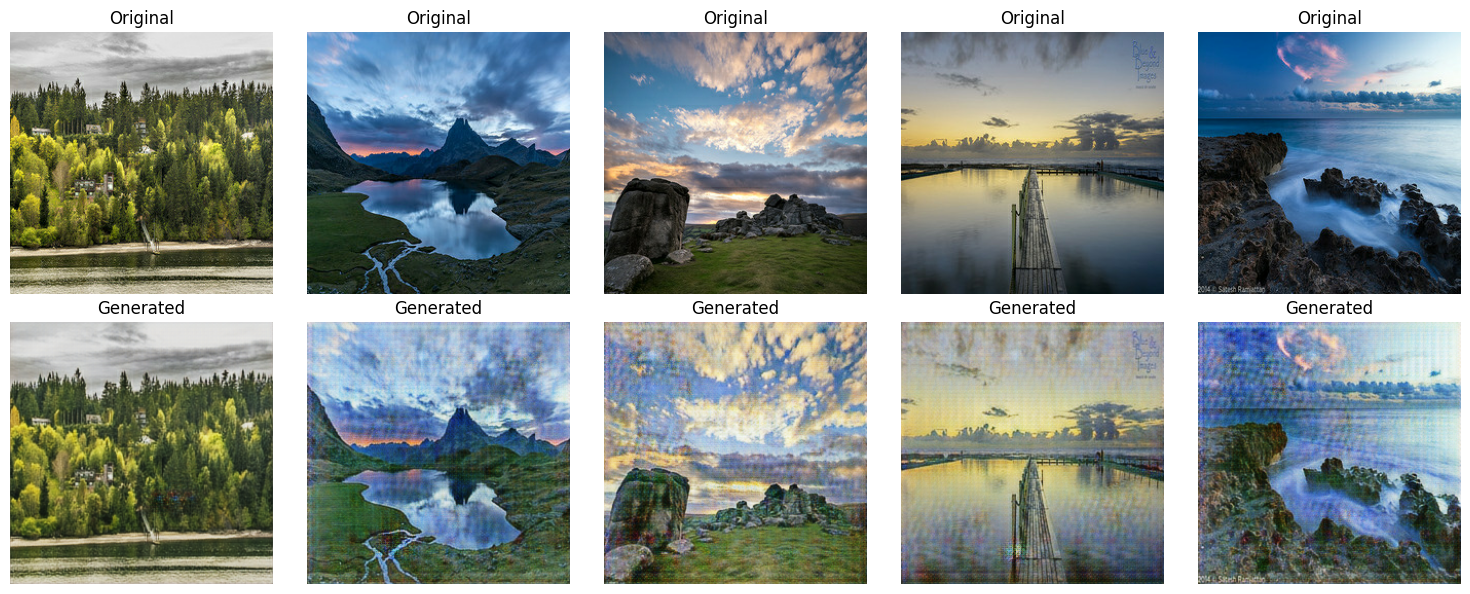

In [20]:
_, ax = plt.subplots(2, 5, figsize=(15, 6))
for i, img in enumerate(photo_ds.take(5)):
    pred = monet_g(img, training=False)[0].numpy()
    pred = (pred * 127.5 + 127.5).astype(np.uint8) # Rescale from [-1, 1] to [0, 255]
    orig = (img[0].numpy() * 127.5 + 127.5).astype(np.uint8)

    ax[0, i].imshow(orig)
    ax[0, i].set_title("Original")
    ax[0, i].axis("off")

    ax[1, i].imshow(pred)
    ax[1, i].set_title("Generated")
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

In [21]:
import zipfile
from PIL import Image

TMP_DIR = "/kaggle/working/tmp"
ZIP_PATH = "/kaggle/working/images.zip"

os.makedirs(TMP_DIR, exist_ok=True)

def denormalize(image):
    image = (image + 1.0) * 127.5
    image = tf.clip_by_value(image, 0, 255)
    return tf.cast(image, tf.uint8)

def generate_and_save_images(dataset):
    counter = 0
    for img_batch in dataset:
        preds = monet_g(img_batch, training=False).numpy()
    
        for i in range(preds.shape[0]):
            img = (preds[i] * 127.5 + 127.5).astype(np.uint8)
            im = Image.fromarray(img)
            im.save(os.path.join(TMP_DIR, f"image_{counter:04d}.jpg"))
            counter += 1

generate_and_save_images(photo_ds)

with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(TMP_DIR):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

num_generated = len(os.listdir(TMP_DIR))
print(f"Generated {num_generated} images.")

Generated 7038 images.


In [22]:
for filename in os.listdir(TMP_DIR):
    os.remove(os.path.join(TMP_DIR, filename))

os.rmdir(TMP_DIR)

After submitting the generated images to Kaggle, I obtained a MiFID score of 59.3, which indicates that the CycleGAN model with the chosen hyperparameters can generate Monet-style images with reasonable visual quality.

## 5. Conclusion

My learning and takeaways are:
* The CycleGAN model with two generators and two discriminators produces better-quality outputs and achieves faster convergence compared to a classic noise-based GAN.
* It likely performs better than a single generator-discriminator pair, because it learns bidirectional mappings between the unpaired images.
* The U-Net structure is effective for style transfer.
* Basic hyperparameter tuning such as learning rates and number of epochs could significantly affect model performance and the quality of generated images.

The discriminators had lower losses than the generators, which is common in GAN training. The imbalance can be improved by:
* Futhur increasing the learning rates for generators or tuning other optimizer parameters.
* Increasing the training steps for the generators.
* Augmenting the real images fed to the discriminators to prevent the discriminators from overfitting due to the limited real dataset.

This notebook was created and trained on Kaggle and can be found in my [GitHub repo](https://github.com/YuKitAs/monet-cycle-gan).

## References

1. Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks (CycleGAN). IEEE International Conference on Computer Vision (ICCV).

2. Ronneberger, O., Fischer, P., & Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. International Conference on Medical Image Computing and Computer-Assisted Intervention (MICCAI).

3. OpenAI. (2025). ChatGPT (GPT-5) [Large language model]. (Only used for phrasing suggestions and idea refinement; all experiments, coding and results were implemented and validated independently.)